### Cutoff Method

This is exploring instead of using a model just using cut-off values to find matches.

In [1]:
# - - - - - - - - - - - #
# Cleaning
# - - - - - - - - - - - #

import pandas as pd
from thefuzz import fuzz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

def get_lev_distance_or_NA(data, columns, partial = False, sort = False):
    assert isinstance(data, pd.DataFrame)
    assert isinstance(columns, list)
    assert len(columns) == 2
    #If partial is True, First column will be fully matched, Second column partially matched
    assert isinstance(columns[0], str)
    assert isinstance(columns[1], str)
    
    out = []
    for i in range(data.shape[0]):
        val1 = data[columns[0]].iloc[i]
        val2 = data[columns[1]].iloc[i]
        if pd.isna(val1) or val1 == "" or pd.isna(val2) or val2 == "":
            out.append(np.nan)
        else:
            if partial and sort:
                out.append(fuzz.partial_token_sort_ratio(val1, val2))
            elif partial:
                out.append(fuzz.partial_ratio(val1, val2))
            elif sort:
                out.append(fuzz.token_sort_ratio(val1, val2))
            else:
                out.append(fuzz.ratio(val1, val2))
    return out

train = pd.read_csv("training_set_final.csv")
test = pd.read_csv("golden_set.csv")

#lev distance for title
train['title_match'] = get_lev_distance_or_NA(train, ['title_ia', 'title_wiki'])
test['title_match'] = get_lev_distance_or_NA(test, ['title_ia', 'title_wiki'])

# using partial matching because title_ia is usually more descriptive
train['title_match_partial'] = get_lev_distance_or_NA(train, ['title_wiki', 'title_ia'], partial = True, sort = True)
test['title_match_partial'] = get_lev_distance_or_NA(test, ['title_wiki', 'title_ia'], partial = True, sort = True)

#for author
train.author_ia = train.author_ia.astype('str')
train.author_wiki = train.author_wiki.astype('str')

test.author_ia = test.author_ia.astype('str')
test.author_wiki = test.author_wiki.astype('str')

for var in ['author_ia', 'author_wiki']:
    train[var] = train[var].replace({'nan': np.nan})
    test[var] = test[var].replace({'nan': np.nan})

train['author_match'] = get_lev_distance_or_NA(train, ['author_ia', 'author_wiki'])
test['author_match'] = get_lev_distance_or_NA(test, ['author_ia', 'author_wiki'])

train['author_sort'] = get_lev_distance_or_NA(train, ['author_ia', 'author_wiki'], sort = True)
test['author_sort'] = get_lev_distance_or_NA(test, ['author_ia', 'author_wiki'], sort = True)

#for publisher
train['publisher_match'] = get_lev_distance_or_NA(train, ['publisher_ia', 'publisher_wiki'])
test['publisher_match'] = get_lev_distance_or_NA(test, ['publisher_ia', 'publisher_wiki'])

# using partial matching because publisher_ia is usually more descriptive
train['publisher_match_partial'] = get_lev_distance_or_NA(train, ['publisher_wiki', 'publisher_ia'], partial = True)
test['publisher_match_partial'] = get_lev_distance_or_NA(test, ['publisher_wiki', 'publisher_ia'], partial = True)


In [2]:
#year
def clean(string):
    if pd.isna(string):
        return np.nan
    string = str(string)
    if any(char.isdigit() for char in string) == False:
        return np.nan
    string = re.subn(r'\.[0-9]+',"",string)[0]
    string = re.subn(r'\.',"",string)[0]
    if string:
        try:
            return int(''.join(filter(str.isdigit, string)))
        except:
            print(string)
    else:
        return np.nan

train.year_wiki = train.year_wiki.apply(clean)
train.date_ia = train.date_ia.apply(clean)
test.year_wiki = test.year_wiki.apply(clean)
test.date_ia = test.date_ia.apply(clean)

year_res = []
for i in range(train.shape[0]):
    val1 = train.date_ia.iloc[i]
    val2 = train.year_wiki.iloc[i]
    if val1 and val2:
        year_res.append(float(val1) == float(val2))
    else:
        year_res.append(np.nan)

train['year_match'] = year_res
        
year_res = []
for i in range(test.shape[0]):
    val1 = test.date_ia.iloc[i]
    val2 = test.year_wiki.iloc[i]
    if val1 and val2:
        year_res.append(float(val1) == float(val2))
    else:
        year_res.append(np.nan)
        
test['year_match'] = year_res

#year NA
train['year_NA'] = [np.where(pd.isna(train.year_wiki.iloc[i]) or pd.isna(train.date_ia.iloc[i]), 1, 0) for i in range(train.shape[0])]
test['year_NA'] = [np.where(pd.isna(test.year_wiki.iloc[i]) or pd.isna(test.date_ia.iloc[i]), 1, 0) for i in range(test.shape[0])]

#Author NA
train['author_NA'] = [np.where(pd.isna(train.author_ia.iloc[i]) or pd.isna(train.author_wiki.iloc[i]), 1, 0) for i in range(train.shape[0])]
test['author_NA'] = [np.where(pd.isna(test.author_ia.iloc[i]) or pd.isna(test.author_wiki.iloc[i]), 1,0) for i in range(test.shape[0])]

#Publisher NA
train['publisher_NA'] = [np.where(pd.isna(train.publisher_ia.iloc[i]) or pd.isna(train.publisher_wiki.iloc[i]), 1, 0) for i in range(train.shape[0])]
test['publisher_NA'] = [np.where(pd.isna(test.publisher_ia.iloc[i]) or pd.isna(test.publisher_wiki.iloc[i]), 1, 0) for i in range(test.shape[0])]

#downsampling NOT NEEDED HERE
has_match = train.groupby('query_count')['citebook_match'].transform(lambda x : any(x == 1)).to_list()
train = train[has_match]

tmp_match = train.query('citebook_match == 1')
tmp_unmatch = train.query('citebook_match == 0') \
    .groupby('query_count') \
    .sample(1)
train = pd.concat([tmp_match, tmp_unmatch])

In [3]:
def prop_NA(data, var):
    print(f'In variable {var}, {round(sum(data[var])/data.shape[0], 3)*100}% are missing in one of the two columns(IA or WIKI)')
    return None

for var in ['year_NA', 'author_NA', 'publisher_NA']:
    prop_NA(train, var)

In variable year_NA, 32.7% are missing in one of the two columns(IA or WIKI)
In variable author_NA, 34.699999999999996% are missing in one of the two columns(IA or WIKI)
In variable publisher_NA, 11.4% are missing in one of the two columns(IA or WIKI)


In [4]:
train.citebook_match.value_counts()/train.shape[0]

0    0.95122
1    0.04878
Name: citebook_match, dtype: float64

In [5]:
test.citebook_match.value_counts()

0    673
1     84
Name: citebook_match, dtype: int64

In [6]:
83/85

0.9764705882352941

#### First I want to make some histograms of matches by distance

[Text(0.5, 1.0, 'Distance of Titles by Link Matches')]

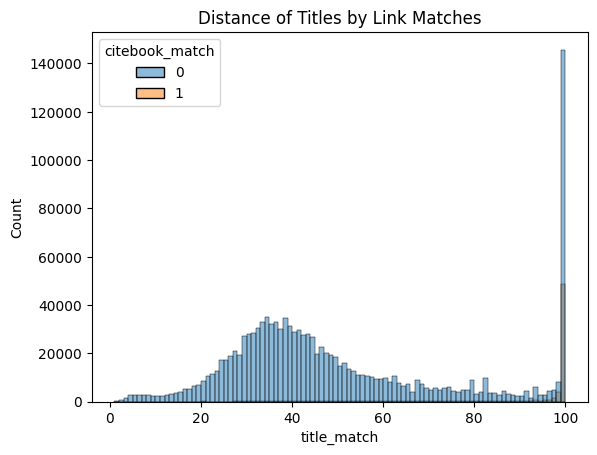

In [7]:
%matplotlib inline
sns.histplot(data=train, x="title_match", hue="citebook_match", binwidth = 1).set(title='Distance of Titles by Link Matches')

[Text(0.5, 1.0, 'Distance of Titles by Link Matches')]

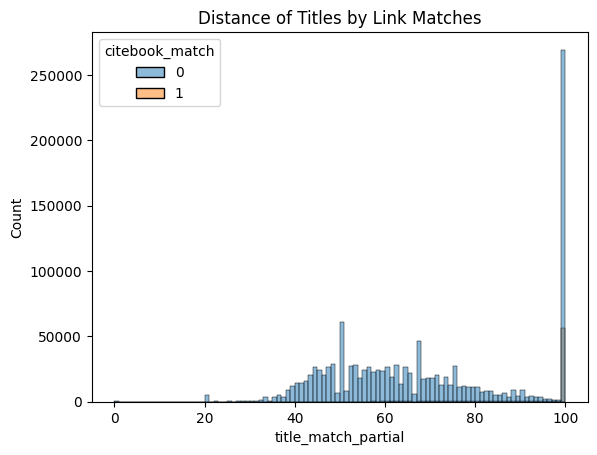

In [8]:
sns.histplot(data=train, x="title_match_partial", hue="citebook_match", binwidth = 1).set(title='Distance of Titles by Link Matches')

[Text(0.5, 1.0, 'Distance of Titles of Matches ONLY')]

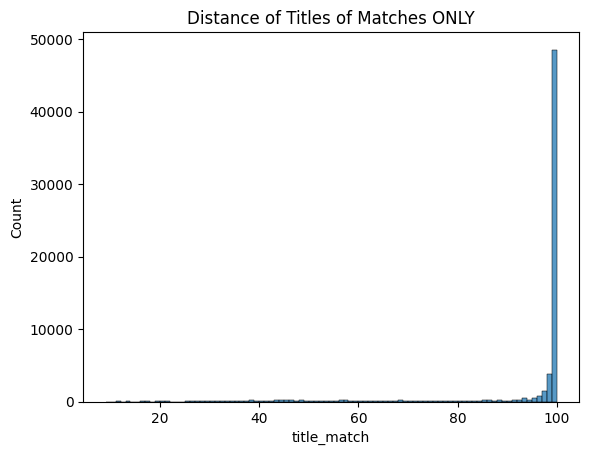

In [9]:
sns.histplot(data=train.query('citebook_match == 1'), x="title_match", binwidth = 1).set(title='Distance of Titles of Matches ONLY')

[Text(0.5, 1.0, 'Distance of Titles of Matches ONLY')]

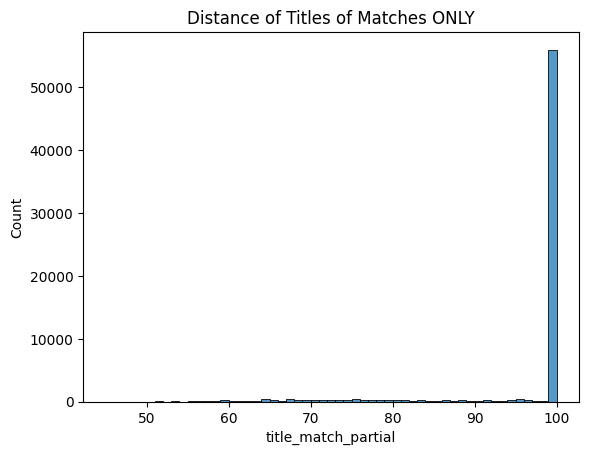

In [10]:
sns.histplot(data=train.query('citebook_match == 1'), x="title_match_partial", binwidth = 1).set(title='Distance of Titles of Matches ONLY')

In [11]:
train.query('citebook_match == 1').title_match_partial.describe()

count    64159.000000
mean        97.098147
std          8.628416
min         45.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: title_match_partial, dtype: float64

In [12]:
for i in range(0,30):
    print(f"{i} : {np.percentile(train.query('citebook_match == 1').title_match_partial,i)}")

0 : 45.0
1 : 61.0
2 : 64.0
3 : 68.0
4 : 70.0
5 : 73.0
6 : 76.0
7 : 78.0
8 : 81.0
9 : 85.0
10 : 88.0
11 : 93.0
12 : 96.0
13 : 100.0
14 : 100.0
15 : 100.0
16 : 100.0
17 : 100.0
18 : 100.0
19 : 100.0
20 : 100.0
21 : 100.0
22 : 100.0
23 : 100.0
24 : 100.0
25 : 100.0
26 : 100.0
27 : 100.0
28 : 100.0
29 : 100.0


In [13]:
for i in range(0,30):
    print(f"{i} : {np.percentile(train.query('citebook_match == 1').title_match,i)}")

0 : 9.0
1 : 33.58000000000004
2 : 39.0
3 : 44.0
4 : 47.0
5 : 52.0
6 : 57.0
7 : 61.0
8 : 67.0
9 : 72.0
10 : 79.0
11 : 84.0
12 : 88.0
13 : 92.0
14 : 94.0
15 : 96.0
16 : 96.0
17 : 97.0
18 : 97.0
19 : 98.0
20 : 98.0
21 : 98.0
22 : 98.0
23 : 98.0
24 : 98.0
25 : 99.0
26 : 99.0
27 : 99.0
28 : 99.0
29 : 99.0


In [14]:
train.query('citebook_match == 1 and title_match_partial < 90').to_csv('investigation.csv')

In [15]:
train.query('citebook_match == 1').title_match.describe()

count    64159.000000
mean        94.168160
std         14.878291
min          9.000000
25%         99.000000
50%         99.000000
75%        100.000000
max        100.000000
Name: title_match, dtype: float64

In [16]:
train.query('citebook_match == 0').title_match.describe()

count    1.251101e+06
mean     5.044278e+01
std      2.540607e+01
min      1.000000e+00
25%      3.300000e+01
50%      4.200000e+01
75%      6.400000e+01
max      1.000000e+02
Name: title_match, dtype: float64

[Text(0.5, 1.0, 'Distance of Authors by Link Matches')]

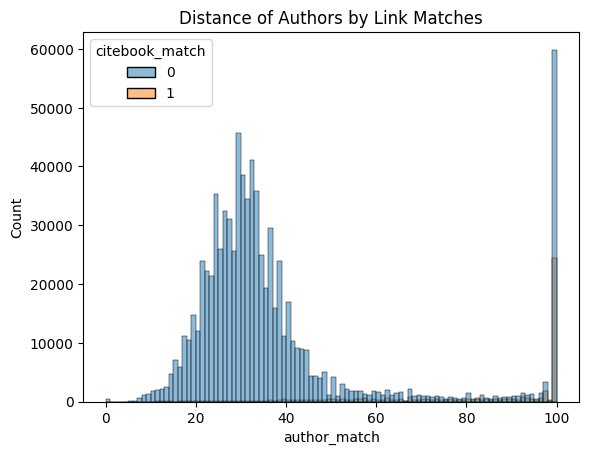

In [17]:
sns.histplot(data=train, x="author_match", hue="citebook_match", binwidth = 1).set(title='Distance of Authors by Link Matches')

[Text(0.5, 1.0, 'Distance of Authors by Link Matches')]

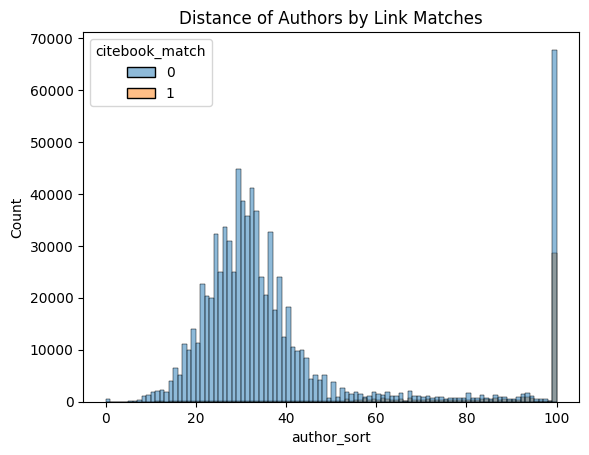

In [18]:
sns.histplot(data=train, x="author_sort", hue="citebook_match", binwidth = 1).set(title='Distance of Authors by Link Matches')

In [19]:
train.query('citebook_match == 1').author_match.describe()

count    50121.000000
mean        83.398655
std         22.318486
min          0.000000
25%         67.000000
50%         97.000000
75%        100.000000
max        100.000000
Name: author_match, dtype: float64

In [20]:
train.query('citebook_match == 0').author_match.describe()

count    808590.000000
mean         37.760390
std          22.156706
min           0.000000
25%          25.000000
50%          31.000000
75%          39.000000
max         100.000000
Name: author_match, dtype: float64

[Text(0.5, 1.0, 'Distance of Authors of Matches ONLY')]

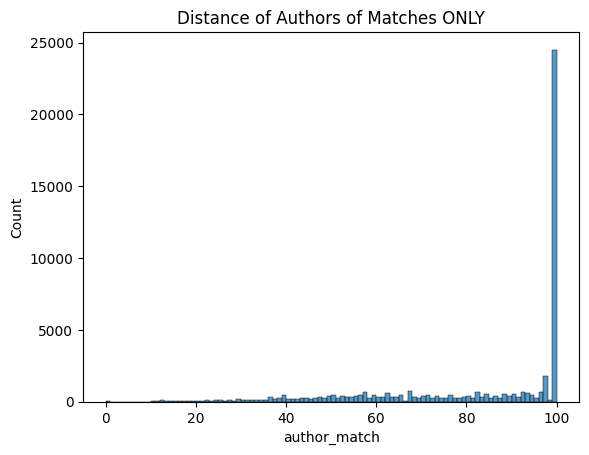

In [21]:
sns.histplot(data=train.query('citebook_match == 1'), x="author_match", binwidth = 1).set(title='Distance of Authors of Matches ONLY')

[Text(0.5, 1.0, 'Distance of Authors of Matches ONLY')]

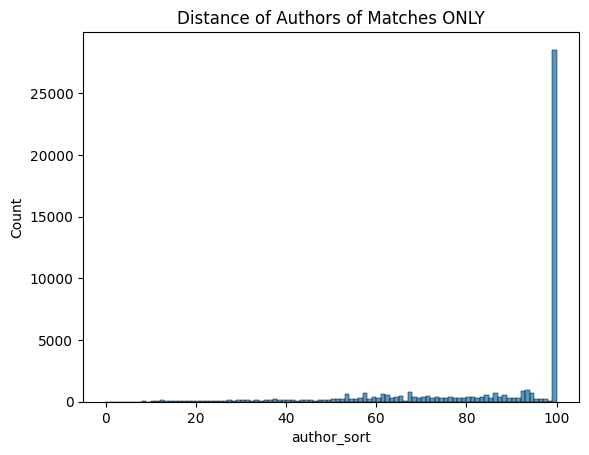

In [22]:
sns.histplot(data=train.query('citebook_match == 1'), x="author_sort", binwidth = 1).set(title='Distance of Authors of Matches ONLY')

[Text(0.5, 1.0, 'Distance of Publishers by Link Matches')]

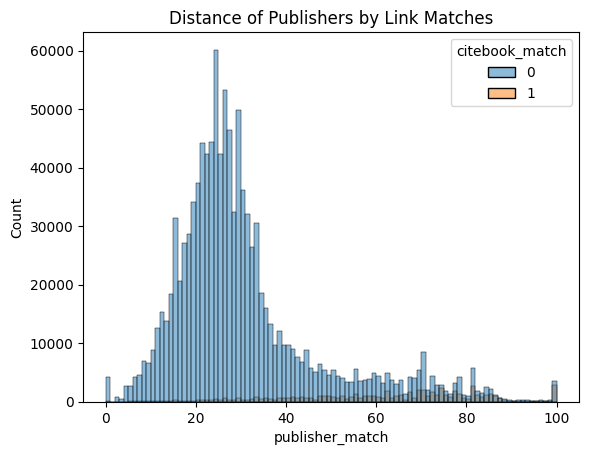

In [23]:
sns.histplot(data=train, x="publisher_match", hue="citebook_match", binwidth = 1).set(title='Distance of Publishers by Link Matches')

[Text(0.5, 1.0, 'Distance of Publishers by Link Matches')]

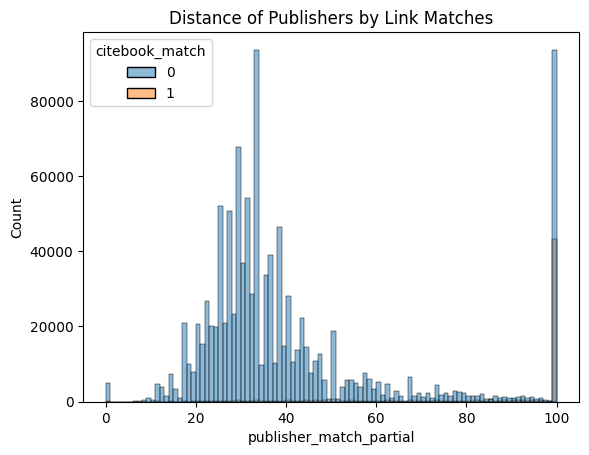

In [24]:
sns.histplot(data=train, x="publisher_match_partial", hue="citebook_match", binwidth = 1).set(title='Distance of Publishers by Link Matches')

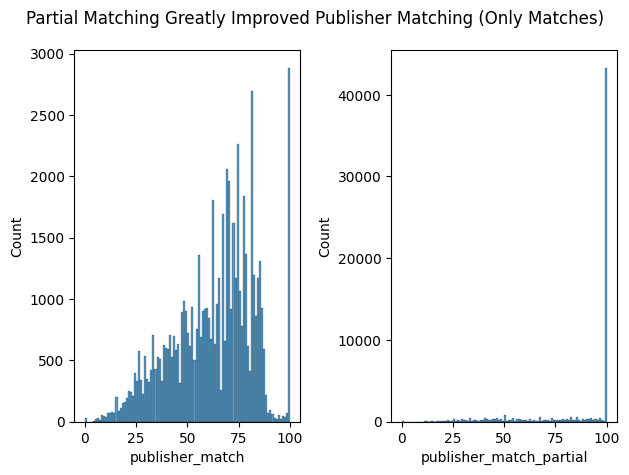

In [25]:
fig, ax = plt.subplots(1, 2)
sns.histplot(data=train.query('citebook_match == 1'), x="publisher_match_partial", binwidth = 1, ax = ax[1])
sns.histplot(data=train.query('citebook_match == 1'), x="publisher_match", binwidth = 1, ax = ax[0])
plt.suptitle("Partial Matching Greatly Improved Publisher Matching (Only Matches)")
fig.tight_layout()
plt.show()

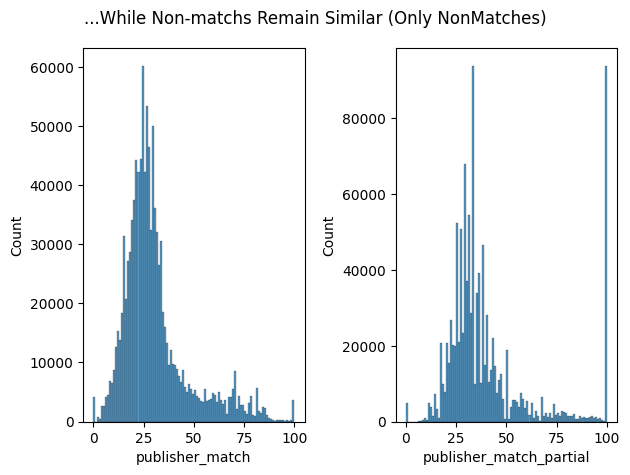

In [26]:
fig, ax = plt.subplots(1, 2)
sns.histplot(data=train.query('citebook_match == 0'), x="publisher_match_partial", binwidth = 1, ax = ax[1])
sns.histplot(data=train.query('citebook_match == 0'), x="publisher_match", binwidth = 1, ax = ax[0])
plt.suptitle("...While Non-matchs Remain Similar (Only NonMatches)")
fig.tight_layout()
plt.show()

[Text(0.5, 1.0, 'Distance of Publishers by Link Matches')]

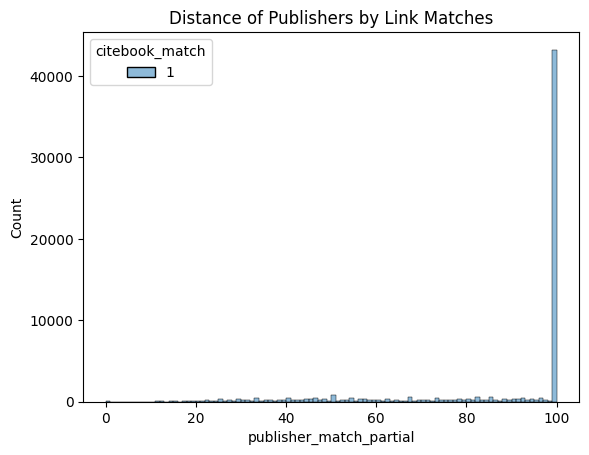

In [27]:
sns.histplot(data=train.query('citebook_match == 1'), x="publisher_match_partial", hue="citebook_match", binwidth = 1).set(title='Distance of Publishers by Link Matches')

[Text(0.5, 1.0, 'Distance of Publishers ONLY')]

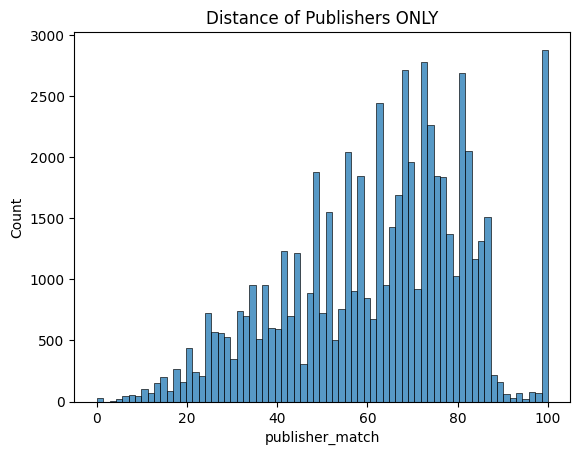

In [28]:
sns.histplot(data=train.query('citebook_match == 1'), x="publisher_match").set(title='Distance of Publishers ONLY')

In [29]:
for i in range(0,101,5):
    print(f"{i} : {np.percentile(train.query('citebook_match == 1').dropna().publisher_match_partial,i)}")

0 : 0.0
5 : 33.0
10 : 46.0
15 : 57.0
20 : 73.0
25 : 88.0
30 : 98.0
35 : 100.0
40 : 100.0
45 : 100.0
50 : 100.0
55 : 100.0
60 : 100.0
65 : 100.0
70 : 100.0
75 : 100.0
80 : 100.0
85 : 100.0
90 : 100.0
95 : 100.0
100 : 100.0


In [30]:
for i in range(0,101,5):
    print(f"{i} : {np.percentile(train.query('citebook_match == 1').dropna().publisher_match,i)}")

0 : 0.0
5 : 25.0
10 : 32.0
15 : 38.0
20 : 43.0
25 : 48.0
30 : 52.0
35 : 55.0
40 : 59.0
45 : 62.0
50 : 65.0
55 : 68.0
60 : 70.0
65 : 72.0
70 : 74.0
75 : 77.0
80 : 79.0
85 : 81.0
90 : 84.0
95 : 89.0
100 : 100.0


In [31]:
train.query('citebook_match == 1').publisher_match.describe()

count    61578.000000
mean        62.528403
std         20.013685
min          0.000000
25%         49.000000
50%         66.000000
75%         77.000000
max        100.000000
Name: publisher_match, dtype: float64

In [32]:
train.query('citebook_match == 0').publisher_match.describe()

count    1.103699e+06
mean     3.027641e+01
std      1.656805e+01
min      0.000000e+00
25%      2.000000e+01
50%      2.600000e+01
75%      3.400000e+01
max      1.000000e+02
Name: publisher_match, dtype: float64

In [33]:
pd.crosstab(train.citebook_match, train.year_match)

year_match,False,True
citebook_match,,
0,1193047,58054
1,22844,41315


#### I want to look at the examples of various lev distances

In [26]:
train.query('author_match == 100').to_csv('investigation.csv', index = False)

In [52]:
print(sum(train.query('citebook_match == 1').author_sort == 100)/train.shape[0])
print(sum(train.query('citebook_match == 1').author_match == 100)/train.shape[0])

0.02169228897708438
0.018629016316165627


In [53]:
print(train.query('citebook_match == 1').author_sort.mean())
print(train.query('citebook_match == 1').author_match.mean())

86.50230442329563
83.39865525428463


In [55]:
print(train.query('citebook_match == 0').author_sort.mean())
print(train.query('citebook_match == 0').author_match.mean())

38.367580603272366
37.760390309056504


### Method:
We're going to use an algorithm that we construct that takes into account the different lev distances and missingness of those lev distances

### Evaluation:
There are two metrics we care about in this study:
1. How many that we guessed right are actually wrong? - precision
2. Of all the possible True positives, how many did we miss?

To calculate this we just need 2 columns: actual and predicted

In [4]:
def get_metrics(data):
    data = data[['citebook_match', 'predicted']]
    metric1 = round((data.query("citebook_match == 1 and predicted == 1").shape[0] / data.query("predicted == 1").shape[0]*100), 3)
    metric2 = round((data.query("citebook_match == 1 and predicted == 1").shape[0] / data.query("citebook_match == 1").shape[0]*100), 3)
    metric3 = round((data.query("predicted == 0").shape[0] / data.shape[0]*100), 3)
    metric4 = round((np.sum(data.predicted == data.citebook_match)/data.shape[0]*100),3)
    print(f'Of all predicted true, {metric1}% are correctly predicted true.')
    print(f'Of all possible true, {metric2}% are correctly predicted true.')
    print(f'accuracy is {metric4}%')
    print(f'Reduced data set by {metric3}%')
    return metric1, metric2, metric3, metric4

In [5]:
def cutoff_algo(row, title_cutoff, author_cutoff, publisher_cutoff, use_year = True):
    author = (author_cutoff != None) and (not pd.isna(row['author_match']))
    publisher = (publisher_cutoff != None) and (not pd.isna(row['publisher_match']))
    
    title_val = row['title_match']
    author_val = row['author_match']
    publisher_val = row['publisher_match']
    year_val = row['year_match']
    
    title_pass = title_val >= title_cutoff
    
    if author:
        if author_val >= author_cutoff:
            author_pass = True
        else:
            author_pass =  False
    else:
        author_pass = True
        
    if publisher:
        if publisher_val >= publisher_cutoff:
            publisher_pass = True
        else:
            publisher_pass =  False
    else:
        publisher_pass = True
    
    if use_year is False:
        year_pass = True
    elif pd.isna(year_val):
        year_pass = True
    else:
        year_pass = year_val
    
    if title_pass and author_pass and publisher_pass and year_pass:
        return 1
    else:
        return 0

In [6]:
tc = 100
ac = None
pc = None
uy = False


train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("train")
get_metrics(train)

test['predicted'] = test.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("test")
get_metrics(test)

train
Of all predicted true, 19.85% are correctly predicted true.
Of all possible true, 44.694% are correctly predicted true.
accuracy is 88.499
Reduced data set by 89.017%
test
Of all predicted true, 61.29% are correctly predicted true.
Of all possible true, 45.238% are correctly predicted true.
accuracy is 90.753
Reduced data set by 91.81%


(61.29, 45.238, 91.81, 90.753)

In [7]:
tc = 100
ac = 100
pc = None
uy = False


train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("train")
get_metrics(train)

test['predicted'] = test.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("test")
get_metrics(test)

train
Of all predicted true, 19.146% are correctly predicted true.
Of all possible true, 25.858% are correctly predicted true.
accuracy is 91.057
Reduced data set by 93.412%
test
Of all predicted true, 74.194% are correctly predicted true.
Of all possible true, 27.381% are correctly predicted true.
accuracy is 90.885
Reduced data set by 95.905%


(74.194, 27.381, 95.905, 90.885)

In [8]:
tc = 100
ac = None
pc = 100
uy = False


train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("train")
get_metrics(train)

test['predicted'] = test.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("test")
get_metrics(test)

train
Of all predicted true, 15.635% are correctly predicted true.
Of all possible true, 5.631% are correctly predicted true.
accuracy is 93.914
Reduced data set by 98.243%
test
Of all predicted true, 75.0% are correctly predicted true.
Of all possible true, 14.286% are correctly predicted true.
accuracy is 89.96
Reduced data set by 97.886%


(75.0, 14.286, 97.886, 89.96)

In [5]:
tc = 100
ac = None
pc = None
uy = True


train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("train")
get_metrics(train)

test['predicted'] = test.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("test")
get_metrics(test)

train
Of all predicted true, 89.427% are correctly predicted true.
Of all possible true, 28.461% are correctly predicted true.
accuracy is 53.179%
Reduced data set by 80.107%
test
Of all predicted true, 100.0% are correctly predicted true.
Of all possible true, 27.381% are correctly predicted true.
accuracy is 91.942%
Reduced data set by 96.962%


(100.0, 27.381, 96.962, 91.942)

In [10]:
tc = 100
ac = 100
pc = 100
uy = True


train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("train")
get_metrics(train)

test['predicted'] = test.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("test")
get_metrics(test)

train
Of all predicted true, 28.748% are correctly predicted true.
Of all possible true, 1.922% are correctly predicted true.
accuracy is 94.983
Reduced data set by 99.674%
test
Of all predicted true, 100.0% are correctly predicted true.
Of all possible true, 7.143% are correctly predicted true.
accuracy is 89.696
Reduced data set by 99.207%


(100.0, 7.143, 99.207, 89.696)

In [7]:
tc = 95
ac = None
pc = None
uy = True


train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("train")
get_metrics(train)

test['predicted'] = test.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("test")
get_metrics(test)

train
Of all predicted true, 85.905% are correctly predicted true.
Of all possible true, 54.829% are correctly predicted true.
accuracy is 66.142%
Reduced data set by 60.104%
test
Of all predicted true, 100.0% are correctly predicted true.
Of all possible true, 45.238% are correctly predicted true.
accuracy is 93.923%
Reduced data set by 94.98%


(100.0, 45.238, 94.98, 93.923)

In [6]:
tc = 95
ac = 90
pc = 90
uy = True


train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("train")
get_metrics(train)

test['predicted'] = test.apply(
    cutoff_algo, 
    title_cutoff = tc,
    author_cutoff = ac,
    publisher_cutoff = pc,
    use_year = uy,
    axis = 1
)

print("test")
get_metrics(test)

train
Of all predicted true, 82.062% are correctly predicted true.
Of all possible true, 3.387% are correctly predicted true.
accuracy is 39.147%
Reduced data set by 97.42%
test
Of all predicted true, 100.0% are correctly predicted true.
Of all possible true, 7.143% are correctly predicted true.
accuracy is 89.696%
Reduced data set by 99.207%


(100.0, 7.143, 99.207, 89.696)

In [37]:
test.to_csv("investigation.csv", index=False)

In [24]:
test['predicted'] = test.apply(
    cutoff_algo, 
    title_cutoff = 95,
    author_cutoff = None,
    publisher_cutoff = None,
    use_year = True,
    axis = 1
)

get_metrics(test)

Of all predicted true, 24.894% are correctly predicted true.
Of all possible true, 85.81% are correctly predicted true.
Reduced data set by 83.185%


(24.894, 85.81, 83.185)

In [25]:
train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = 97,
    author_cutoff = 95,
    publisher_cutoff = None,
    use_year = False,
    axis = 1
)

get_metrics(train)

Of all predicted true, 25.295% are correctly predicted true.
Of all possible true, 54.223% are correctly predicted true.
Reduced data set by 89.543%


(25.295, 54.223, 89.543)

In [26]:
train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = 97,
    author_cutoff = 80,
    publisher_cutoff = 50,
    use_year = False,
    axis = 1
)

get_metrics(train)

Of all predicted true, 34.954% are correctly predicted true.
Of all possible true, 47.741% are correctly predicted true.
Reduced data set by 93.338%


(34.954, 47.741, 93.338)

In [27]:
train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = 97,
    author_cutoff = 80,
    publisher_cutoff = 50,
    use_year = True,
    axis = 1
)

get_metrics(train)

Of all predicted true, 50.608% are correctly predicted true.
Of all possible true, 31.833% are correctly predicted true.
Reduced data set by 96.932%


(50.608, 31.833, 96.932)

In [28]:
train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = 95,
    author_cutoff = 70,
    publisher_cutoff = 30,
    use_year = True,
    axis = 1
)

get_metrics(train)

Of all predicted true, 50.809% are correctly predicted true.
Of all possible true, 42.19% are correctly predicted true.
Reduced data set by 95.949%


(50.809, 42.19, 95.949)

In [29]:
train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = 95,
    author_cutoff = 50,
    publisher_cutoff = None,
    use_year = True,
    axis = 1
)

get_metrics(train)

Of all predicted true, 49.234% are correctly predicted true.
Of all possible true, 50.459% are correctly predicted true.
Reduced data set by 95.001%


(49.234, 50.459, 95.001)

In [30]:
train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = 95,
    author_cutoff = None,
    publisher_cutoff = None,
    use_year = True,
    axis = 1
)

get_metrics(train)

Of all predicted true, 49.37% are correctly predicted true.
Of all possible true, 54.829% are correctly predicted true.
Reduced data set by 94.583%


(49.37, 54.829, 94.583)

In [31]:
train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = 95,
    author_cutoff = 10,
    publisher_cutoff = 10,
    use_year = True,
    axis = 1
)

get_metrics(train)

Of all predicted true, 49.522% are correctly predicted true.
Of all possible true, 54.708% are correctly predicted true.
Reduced data set by 94.611%


(49.522, 54.708, 94.611)

In [32]:
train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = 97,
    author_cutoff = 90,
    publisher_cutoff = 20,
    use_year = True,
    axis = 1
)

get_metrics(train)

Of all predicted true, 47.938% are correctly predicted true.
Of all possible true, 36.735% are correctly predicted true.
Reduced data set by 96.262%


(47.938, 36.735, 96.262)

In [33]:
test['predicted'] = test.apply(
    cutoff_algo, 
    title_cutoff = 95,
    author_cutoff = 70,
    publisher_cutoff = 30,
    use_year = True,
    axis = 1
)

get_metrics(test)

Of all predicted true, 66.667% are correctly predicted true.
Of all possible true, 41.667% are correctly predicted true.
Reduced data set by 96.037%


(66.667, 41.667, 96.037)

In [34]:
test['predicted'] = test.apply(
    cutoff_algo, 
    title_cutoff = 95,
    author_cutoff = 10,
    publisher_cutoff = 10,
    use_year = True,
    axis = 1
)

get_metrics(test)

Of all predicted true, 65.789% are correctly predicted true.
Of all possible true, 52.083% are correctly predicted true.
Reduced data set by 94.98%


(65.789, 52.083, 94.98)

In [35]:
test['predicted'] = test.apply(
    cutoff_algo, 
    title_cutoff = 60,
    author_cutoff = None,
    publisher_cutoff = None,
    use_year = False,
    axis = 1
)

get_metrics(test)

Of all predicted true, 21.393% are correctly predicted true.
Of all possible true, 89.583% are correctly predicted true.
Reduced data set by 73.448%


(21.393, 89.583, 73.448)

In [36]:
train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = 50,
    author_cutoff = None,
    publisher_cutoff = None,
    use_year = False,
    axis = 1
)

get_metrics(train)

Of all predicted true, 11.523% are correctly predicted true.
Of all possible true, 95.511% are correctly predicted true.
Reduced data set by 59.568%


(11.523, 95.511, 59.568)

In [37]:
train['predicted'] = train.apply(
    cutoff_algo, 
    title_cutoff = 90,
    author_cutoff = None,
    publisher_cutoff = None,
    use_year = False,
    axis = 1
)

get_metrics(train)

Of all predicted true, 23.531% are correctly predicted true.
Of all possible true, 87.793% are correctly predicted true.
Reduced data set by 81.8%


(23.531, 87.793, 81.8)

In [38]:
train.query("predicted == 0 and citebook_match == 1").to_csv('golden_set_predicted.csv')


In [12]:
train.query('citebook_match == 1').title_match.describe()

count    64159.000000
mean        94.168160
std         14.878291
min          9.000000
25%         99.000000
50%         99.000000
75%        100.000000
max        100.000000
Name: title_match, dtype: float64

In [11]:
train.query('citebook_match == 1').author_sort.describe()

count    50121.000000
mean        86.502304
std         20.216504
min          0.000000
25%         75.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: author_sort, dtype: float64

In [13]:
train.query('citebook_match == 1').publisher_match_partial.describe()

count    61578.000000
mean        88.481763
std         21.740961
min          0.000000
25%         88.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: publisher_match_partial, dtype: float64